<a id="99"></a>
# Python 7 Assignment
### Purpose: To Run Ridge and Lasso Regression using Cross-Validation and Compare with Least Squares Regression
<b>Program Sections</b>
<ul><b>
<li><a href = "#0">Import Python Packages and Set Display</a></li>
<li><a href = "#1">Load the Data and Inspect Fields</a></li>
<li><a href = "#2">Setting Up Data for Regression Models</a></li>
<li><a href = "#3">Data Science Regression Models</a></b>
    <ul><i>
        <li><a href = "#30">Least Square Regression using Recursive Feature Elimination</a></li>
        <li><a href = "#31">An Abitrary Ridge Regression Model</a></li>
        <li><a href = "#32">An Abitrary Lasso Regression Model</a></li>
    </i></ul>
</li><b>
<li><a href = "#4">Cross-Validated Search for Lambda</a></b>
    <ul><i>
        <li><a href = "#40">Ridge Regression</a></li>
        <li><a href = "#41">Lasso Regression</a></li>
    </i></ul>
</li><b>
<li><a href = "#5">Utilizing a Search Grid for Lambda</a></b>
    <ul><i>
        <li><a href = "#50">Ridge Regression</a></li>
        <li><a href = "#51">Lasso Regression</a></li>
    </i></ul>
</li><b>
<li><a href = "#6">Compare Results from Ridge, Lasso, and Least Squares Regression</a></li>
<li><a href = "#7">Assignment Submission</a></li></ul>

<a id="0"></a>
### Import Python Packages and Set Display
<a href = "#99">Top</a>

In [23]:
# Code Block 0
import pandas as pd 
import seaborn as sns
import numpy as np
from numpy import arange

from matplotlib import pyplot as plt
from matplotlib import style

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

import datetime, socket

In [2]:
# Code Block 1
# Set display to show up to 200 columns in dataframe
pd.set_option('display.max_columns', 200) 

# Set default color palette to colorblind
plt.style.use('seaborn-colorblind')

# Set the aesthetic style of any plots 
sns.set_style('whitegrid') 

<a id="1"></a>
### Load the Data and Inspect Fields
<a href = "#99">Top</a>

In [3]:
# Code Block 2
# Read CSV file from previous homework into dataframe
df_airbnb = pd.read_csv('Boston Airbnb Data with features.csv', encoding='latin1')

In [4]:
# Code Block 3
# Identify fields in dataframe
df_airbnb.columns

Index(['ID', 'Name', 'Host ID', 'Host Name', 'Host Since', 'Host Location',
       'Host Response Time', 'Host Response Rate', 'Host Acceptance Rate',
       'Host Is Superhost', 'Host Listings Count', 'Host Has Profile Pic',
       'Host Identity Verified', 'City', 'Property Type', 'Room Type',
       'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type', 'Price',
       'Security Deposit', 'Cleaning Fee', 'Guests Included', 'Extra People',
       'Minimum Nights', 'Number Of Reviews', 'First Review', 'Last Review',
       'Instant Bookable', 'Cancellation Policy', 'Reviews Per Month',
       'City Bins', 'superhost_Yes', 'verified_Yes', 'property_Apartment',
       'property_Bed & Breakfast', 'property_Boat', 'property_Condominium',
       'property_House', 'property_Loft', 'property_Townhouse',
       'property_Villa', 'room_Entire home/apt', 'room_Private room',
       'room_Shared room', 'bed_Airbed', 'bed_Couch', 'bed_Futon',
       'bed_Pull-out Sofa', 'bed_Real Bed', 'ins

In [5]:
# Code Block 4
# Show data type and missing data in fields
df_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3244 entries, 0 to 3243
Data columns (total 79 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           3244 non-null   int64  
 1   Name                         3244 non-null   object 
 2   Host ID                      3244 non-null   int64  
 3   Host Name                    3244 non-null   object 
 4   Host Since                   3244 non-null   object 
 5   Host Location                3234 non-null   object 
 6   Host Response Time           3244 non-null   object 
 7   Host Response Rate           2820 non-null   float64
 8   Host Acceptance Rate         2782 non-null   float64
 9   Host Is Superhost            3244 non-null   object 
 10  Host Listings Count          3244 non-null   int64  
 11  Host Has Profile Pic         3244 non-null   object 
 12  Host Identity Verified       3244 non-null   object 
 13  City              

<a id="2"></a>
### Setting Up Data for Regression Models
<a href = "#99">Top</a>

In [6]:
# Code Block 5
# Create a dataframe with all fields to be used in the regression
df_reg = df_airbnb[['Host Listings Count', 'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 
                    'Security Deposit', 'Cleaning Fee', 'Guests Included', 'Extra People',
                    'Minimum Nights', 'superhost_Yes', 'verified_Yes', 'property_Apartment',
                    'property_Bed & Breakfast', 'property_Boat', 'property_Condominium',
                    'property_House', 'property_Loft', 'property_Townhouse', 'property_Villa',
                    'room_Entire home/apt', 'room_Private room', 'room_Shared room',
                    'bed_Airbed', 'bed_Couch', 'bed_Futon', 'bed_Pull-out Sofa', 'bed_Real Bed',
                    'instabook_Yes', 'cancel_flexible', 'cancel_moderate', 'cancel_strict',
                    'cancel_super_strict_30', 'citybins_Boston', 'citybins_Brookline', 
                    'citybins_Cambridge', 'citybins_Charlestown', 'citybins_Jamaica Plain', 
                    'citybins_Other', 'Has Security Deposit', 'Guests Not Included', 
                    'Guests per Bed', 'Accommodates per Bathroom', 'Days Since Last Review',
                    'Near Fenway', 'Near Harbor', 'Near Historic', 'Price']].copy()

# Drop rows that are not complete (i.e. have missing values)
df_reg.dropna(inplace = True)

# Set up target dataframe
y = df_reg[['Price']].copy()
y.reset_index(drop=True, inplace=True) 

# Set up features dataframe
X = df_reg.drop(['Price'], axis=1)
X.reset_index(drop=True, inplace=True) 

<a id="3"></a>
### Data Science Regression Models
<a href = "#99">Top</a>

<a id="30"></a>
#### Least Square Regression using Recursive Feature Elimination 

In [7]:
# Code Block 6
# Set up scaler to put features on same basis
std_scaler = StandardScaler()

# Apply scaler to entirety of features
X_scaled = std_scaler.fit_transform(X)

# Define recursive elimination search using cross-validated folds and scoring
rfe = RFECV(estimator=LinearRegression(), step=1, n_jobs=-2,
            cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=42), 
            scoring='neg_mean_absolute_error')

# Fit defined RFE model to scaled data
rfe_model = rfe.fit(X_scaled,y)

# Use binary results to populate new feature dataframe with chosen features
X_rfe = X[X.columns[rfe_model.support_]]

In [9]:
# Code Block 7
# Fit regression model on RFE chosen set of features
reg = sm.OLS(y, sm.add_constant(X_rfe)).fit()

# Create predictions and store in a list
ls_pred = reg.predict(sm.add_constant(X_rfe)) 

# Create residuals in a list
ls_resid = reg.resid

# Show summary statistics for regression
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     110.6
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        09:29:56   Log-Likelihood:                -18367.
No. Observations:                3244   AIC:                         3.680e+04
Df Residuals:                    3209   BIC:                         3.702e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        55.5287      5.470     10.151      0.000      44.803      66.254
Accommodates                 17.2585      1.395     12.369      0.000      14.523      19.994
Bedrooms                     25.0904      2.839      8.837      0.000      19.523      30.657
Security Deposit              0.0756      0.011      7.037      0.000       0.055       0.097
Cleaning Fee                  0.1094      0.037      2.941      0.003       0.036       0.182
Guests Included               9.4862      1.209      7.844      0.000       7.115      11.857
Minimum Nights               -0.9549      0.341     -2.803      0.005      -1.623      -0.287
superhost_Yes                 9.6175      3.923      2.452      0.014       1.926      17.309
property_Apartment          -14.4145      5.064     -2.846      0.004     -24.343      -4.485
property_Bed & Breakfast     19.5181     11.533      1.692      0.091      -3.094      42.131
property_Boat                24.9361     19.345      1.289      0.197     -12.993      62.866
property_Condominium          0.2940      6.471      0.045      0.964     -12.393      12.981
property_House              -30.8666      5.638     -5.475      0.000     -41.921     -19.812
property_Loft                 3.5351     11.240      0.315      0.753     -18.504      25.574
property_Townhouse            2.8060     10.066      0.279      0.780     -16.931      22.543
property_Villa               49.7204     25.552      1.946      0.052      -0.379      99.820
room_Entire home/apt         66.7155      4.427     15.072      0.000      58.036      75.395
room_Private room            -6.5371      3.928     -1.664      0.096     -14.239       1.165
room_Shared room             -4.6497      7.089     -0.656      0.512     -18.548       9.249
bed_Airbed                    9.5027     12.306      0.772      0.440     -14.625      33.631
bed_Couch                    20.3405     22.247      0.914      0.361     -23.279      63.960
bed_Futon                    -2.9207     10.299     -0.284      0.777     -23.114      17.273
bed_Pull-out Sofa             7.8488     11.888      0.660      0.509     -15.459      31.157
bed_Real Bed                 20.7574      6.851      3.030      0.002       7.325      34.190
instabook_Yes               -15.9217      3.398     -4.685      0.000     -22.585      -9.259
cancel_flexible              -7.5441      3.079     -2.450      0.014     -13.581      -1.507
cancel_moderate              -3.3214      3.041     -1.092      0.275      -9.285       2.642
cancel_strict               -12.5116      2.886     -4.336      0.000     -18.170      -6.854
cancel_super_strict_30       78.9058      7.033     11.219      0.000      65.116      92.696
citybins_Boston               7.5564      5.883      1.284      0.199      

<Figure size 864x504 with 0 Axes>

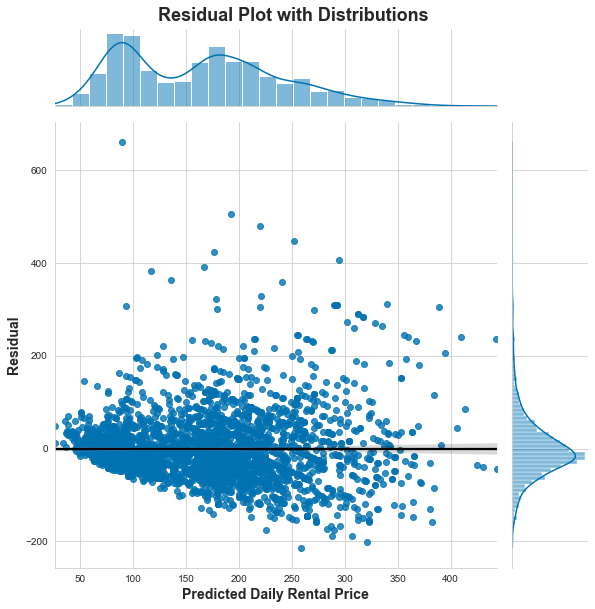

In [10]:
# Code Block 8
# Create plot of residuals along with distributions
plt.figure(figsize=(12,7))
sns.jointplot(x=ls_pred, y=ls_resid, kind="reg",
              ratio=5, height=8, 
              line_kws={'color': 'black'})

plt.xlabel('Predicted Daily Rental Price', 
           fontweight='bold', fontsize='14', ha='center')

plt.ylabel('Residual', 
           fontweight='bold', fontsize='14', ha='center')

plt.suptitle('Residual Plot with Distributions       ',  
             fontweight='bold', fontsize='18', ha='center', y=1.02)
plt.show()

In [12]:
# Code Block 9
# Store coefficients of model in a dataframe for later comparison
ls_coeff = pd.DataFrame()

#  Store feature names in column
ls_coeff["Feature"] = sm.add_constant(X_rfe).columns

# Store feature coefficients in column
ls_params = reg.params.to_frame()
ls_coeff['Least Squares (RFE) Coefficient'] = ls_params.reset_index()[0]

# Show results
ls_coeff

,Feature,Least Squares (RFE) Coefficient
0,const,55.528683
1,Accommodates,17.258469
2,Bedrooms,25.090398
3,Security Deposit,0.075594
4,Cleaning Fee,0.109407
5,Guests Included,9.486227
6,Minimum Nights,-0.954911
7,superhost_Yes,9.617530
8,property_Apartment,-14.414476
9,property_Bed & Breakfast,19.518077


<a id="31"></a>
#### An Arbitrary Ridge Regression Model

In [13]:
# Code Block 10
# Set ridge regression parameters
ridge_reg = Ridge(alpha=500, fit_intercept=False, normalize=True)

# Create line on regression data and show fit
ridge_reg.fit(sm.add_constant(X), y)
print('Ridge Regression R-squared: % 0.3f' % ridge_reg.score(sm.add_constant(X),y))

# Create predictions in a series
ridge_pred = pd.Series(ridge_reg.predict(sm.add_constant(X)).T[0])

# Create residuals in a series
ridge_resid = y['Price'] - ridge_pred

# Show regression coefficients for features
ridge_coeff = pd.DataFrame()
ridge_coeff['Feature'] = sm.add_constant(X).columns
ridge_coeff['Coefficient'] = np.transpose(ridge_reg.coef_)
ridge_coeff

Ridge Regression R-squared:  0.496


,Feature,Coefficient
0,const,9.887857
1,Host Listings Count,0.048667
2,Accommodates,13.014923
3,Bathrooms,14.532847
4,Bedrooms,15.493731
5,Beds,6.566819
6,Security Deposit,0.059425
7,Cleaning Fee,0.211811
8,Guests Included,6.070427
9,Extra People,-0.119086


<Figure size 864x504 with 0 Axes>

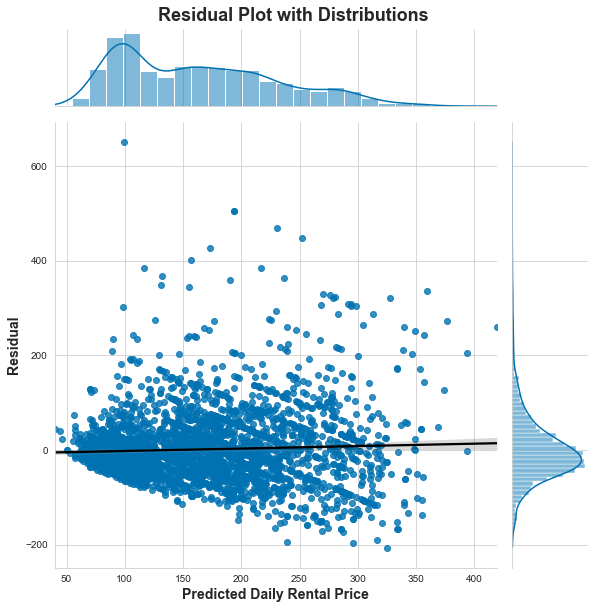

In [14]:
# Code Block 11
# Create plot of residuals along with distributions
plt.figure(figsize=(12,7))
sns.jointplot(x=ridge_pred, y=ridge_resid, kind="reg",
              ratio=5, height=8, 
              line_kws={'color': 'black'})

plt.xlabel('Predicted Daily Rental Price', 
           fontweight='bold', fontsize='14', ha='center')

plt.ylabel('Residual', 
           fontweight='bold', fontsize='14', ha='center')

plt.suptitle('Residual Plot with Distributions       ',  
             fontweight='bold', fontsize='18', ha='center', y=1.02)
plt.show()

<a id="32"></a>
##### An Arbiitrary Lasso Regression Model

In [15]:
# Code Block 12
# Set lasso regression parameters
lasso_reg = Lasso(alpha=5, fit_intercept=False, normalize=True)

# Create line on regression data and show fit
lasso_reg.fit(sm.add_constant(X),y)
print('Lasso Regression R-squared: % 0.3f' % lasso_reg.score(sm.add_constant(X),y))

# Create predictions in a series
lasso_pred = pd.Series(lasso_reg.predict(sm.add_constant(X)).reshape(-1,1).T[0])

# Create residuals in a series
lasso_resid = y['Price'] - lasso_pred

# Show regression coefficients for features
lasso_coeff = pd.DataFrame()
lasso_coeff["Feature"] = sm.add_constant(X).columns
lasso_coeff["Coefficient"] = np.transpose(lasso_reg.coef_)
lasso_coeff

Lasso Regression R-squared:  0.459


,Feature,Coefficient
0,const,0.000000
1,Host Listings Count,0.047153
2,Accommodates,20.043586
3,Bathrooms,21.808376
4,Bedrooms,12.937316
5,Beds,0.000000
6,Security Deposit,0.045167
7,Cleaning Fee,0.224525
8,Guests Included,0.000000
9,Extra People,-0.011139


<Figure size 864x504 with 0 Axes>

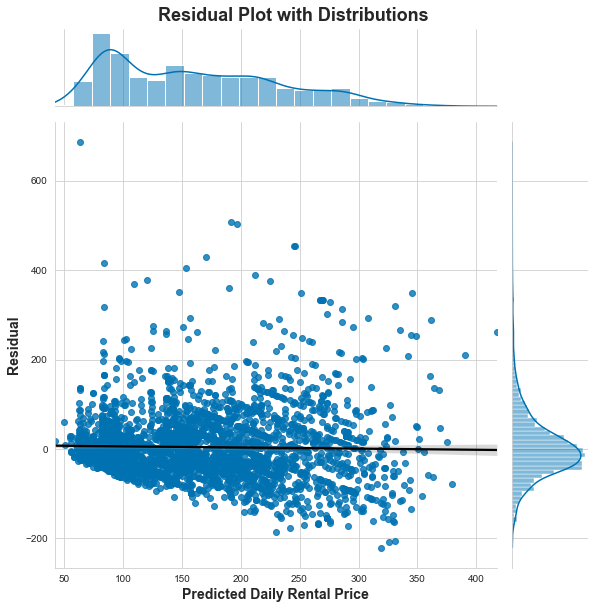

In [16]:
# Code Block 13
# Create plot of residuals along with distributions
plt.figure(figsize=(12,7))
sns.jointplot(x=lasso_pred, y=lasso_resid, kind="reg",
              ratio=5, height=8, 
              line_kws={'color': 'black'})

plt.xlabel('Predicted Daily Rental Price', 
           fontweight='bold', fontsize='14', ha='center')

plt.ylabel('Residual', 
           fontweight='bold', fontsize='14', ha='center')

plt.suptitle('Residual Plot with Distributions       ',  
             fontweight='bold', fontsize='18', ha='center', y=1.02)
plt.show()

<a id="4"></a>
### Cross-Validated Search for Lambda
<a href = "#99">Top</a>

<a id="40"></a>
#### Ridge Regression

In [17]:
# Code Block 14
# Using 10-fold cross-validation, calculate the mean absolute error for the test fold. There
# will be 10 error values for each model.  Evaluate ridge regression models at different levels 
# of lambda (alpha).

rrscores5   = -cross_val_score(Ridge(fit_intercept=False, normalize=True, alpha=5), 
                              sm.add_constant(X), y, cv=10, scoring='neg_mean_absolute_error')
rrscores10  = -cross_val_score(Ridge(fit_intercept=False, normalize=True, alpha=10), 
                              sm.add_constant(X), y, cv=10, scoring='neg_mean_absolute_error')
rrscores50  = -cross_val_score(Ridge(fit_intercept=False, normalize=True, alpha=50), 
                              sm.add_constant(X), y, cv=10, scoring='neg_mean_absolute_error')
rrscores100 = -cross_val_score(Ridge(fit_intercept=False, normalize=True, alpha=100), 
                              sm.add_constant(X), y, cv=10, scoring='neg_mean_absolute_error')
rrscores500 = -cross_val_score(Ridge(fit_intercept=False, normalize=True, alpha=500), 
                              sm.add_constant(X), y, cv=10, scoring='neg_mean_absolute_error')

# Put mean absolute error values into a dataframe with headers
scores_list = {'$\lambda$=5': rrscores5, '$\lambda$=10': rrscores10, '$\lambda$=50': rrscores50,
               '$\lambda$=100': rrscores100, '$\lambda$=500': rrscores500}

df_ridgescores = pd.DataFrame(scores_list)

# Show results of 10 runs for each lambda (alpha) level
print('Ridge Regression Results\nMean Absolute Error')
df_ridgescores

Ridge Regression Results
Mean Absolute Error


,$\lambda$=5,$\lambda$=10,$\lambda$=50,$\lambda$=100,$\lambda$=500
0,44.577972,44.491160,44.383953,44.609535,46.507307
1,47.608538,47.474858,47.111940,47.049778,48.601616
2,45.202111,45.280216,45.755471,46.215431,48.321415
3,50.086764,50.101970,50.188285,50.383001,52.640160
4,51.462085,51.540662,51.961718,52.306833,54.411732
5,45.905165,45.995263,46.463081,46.859928,49.097089
6,45.940605,45.957159,46.188623,46.510691,47.954557
7,55.995908,56.116222,56.544618,56.745364,57.934328
8,49.932271,49.984451,50.104066,50.188873,51.670063
9,45.948760,45.857693,45.806277,46.021132,47.642347


In [18]:
# Code Block 15
# Calculate basic statistics on r-squared values for each set of runs
print('Statistics on Cross Validation Results\nMean Absolute Error')
df_ridgescores.describe()

Statistics on Cross Validation Results
Mean Absolute Error


,$\lambda$=5,$\lambda$=10,$\lambda$=50,$\lambda$=100,$\lambda$=500
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,48.266018,48.279965,48.450803,48.689057,50.478061
std,3.587477,3.632393,3.730462,3.708379,3.612028
min,44.577972,44.491160,44.383953,44.609535,46.507307
25%,45.914025,45.882560,45.901864,46.289246,48.046272
50%,46.778649,46.735060,46.787510,46.954853,48.849353
75%,50.048141,50.072590,50.167230,50.334469,52.397636
max,55.995908,56.116222,56.544618,56.745364,57.934328


<a id="41"></a>
#### Lasso Regression

In [20]:
# Code Block 16
# Using 10-fold cross-validation, calculate the mean absolute error for the test fold. There
# will be 10 error values for each model.  Evaluate lasso regression models at different levels 
# of lambda (alpha).


lascores05 = -cross_val_score(Lasso(fit_intercept=False, normalize=True, max_iter=3000, alpha=0.50),
                              sm.add_constant(X), y, cv=10, scoring='neg_mean_absolute_error')
lascores1  = -cross_val_score(Lasso(fit_intercept=False, normalize=True, max_iter=3000, alpha=1), 
                              sm.add_constant(X), y, cv=10, scoring='neg_mean_absolute_error')
lascores2  = -cross_val_score(Lasso(fit_intercept=False, normalize=True, max_iter=3000, alpha=2), 
                              sm.add_constant(X), y, cv=10, scoring='neg_mean_absolute_error')
lascores3  = -cross_val_score(Lasso(fit_intercept=False, normalize=True, max_iter=3000, alpha=3), 
                              sm.add_constant(X), y, cv=10, scoring='neg_mean_absolute_error')
lascores4  = -cross_val_score(Lasso(fit_intercept=False, normalize=True, max_iter=3000, alpha=4), 
                              sm.add_constant(X), y, cv=10, scoring='neg_mean_absolute_error')
lascores5  = -cross_val_score(Lasso(fit_intercept=False, normalize=True, max_iter=3000, alpha=5), 
                              sm.add_constant(X), y, cv=10, scoring='neg_mean_absolute_error')


# Put r-squared values into a dataframe with headers
scores_list = {'$\lambda$=.50': lascores05, '$\lambda$=1': lascores1, '$\lambda$=2': lascores2,
               '$\lambda$=3': lascores3,'$\lambda$=4': lascores4, '$\lambda$=5': lascores5}

df_lassoscores = pd.DataFrame(scores_list)

# Show results of 10 runs for each lambda (alpha) level
print('Lasso Regression Results\nMean Absolute Error')
df_lassoscores

Lasso Regression Results
Mean Absolute Error


,$\lambda$=.50,$\lambda$=1,$\lambda$=2,$\lambda$=3,$\lambda$=4,$\lambda$=5
0,44.094513,44.845805,46.238741,47.226804,48.228761,48.985678
1,46.816273,47.054560,48.046621,48.678406,49.254101,49.718965
2,45.754043,46.768531,48.617450,49.293896,49.761174,50.216776
3,49.911336,50.290993,52.108751,52.730453,53.386075,53.795872
4,51.677601,52.113650,53.453017,54.602767,55.414434,56.051685
5,46.655626,47.431765,49.056769,49.800717,50.413927,50.650867
6,46.115068,46.483514,47.176280,47.770867,48.452931,48.674994
7,56.515549,57.458331,58.345295,58.772394,59.038816,59.247706
8,49.675489,49.982580,51.171723,52.137326,52.852031,53.176101
9,45.335668,45.334449,46.061785,46.798908,47.649923,48.090310


In [21]:
# Code Block 17
# Calculate basic statistics on r-squared values for each set of runs
print('Statistics on Cross Validation Results\nMean Absolute Error')
df_lassoscores.describe()

Statistics on Cross Validation Results
Mean Absolute Error


,$\lambda$=.50,$\lambda$=1,$\lambda$=2,$\lambda$=3,$\lambda$=4,$\lambda$=5
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,48.255117,48.776418,50.027643,50.781254,51.445217,51.860895
std,3.741750,3.824196,3.824282,3.789633,3.675257,3.636098
min,44.094513,44.845805,46.061785,46.798908,47.649923,48.090310
25%,45.844300,46.554768,47.393865,47.997752,48.653223,49.169000
50%,46.735950,47.243162,48.837109,49.547306,50.087550,50.433822
75%,49.852374,50.213890,51.874494,52.582172,53.252564,53.640929
max,56.515549,57.458331,58.345295,58.772394,59.038816,59.247706


<a id="5"></a>
### Utilizing a Search Grid for Lambda
<a href = "#99">Top</a>

<a id="50"></a>
#### Ridge Regression

In [26]:
# Code Block 18
# Define technique to be used
ridge_model = Ridge(fit_intercept=False, normalize=True)

# Define cross validation approach
crossval = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

# Define search grid for alpha hyperparameter
search_grid = dict()
# Set range and increments within range
search_grid['alpha'] = arange(0, 10, 0.1)

# Define and perform the search
search = GridSearchCV(ridge_model, search_grid, scoring='neg_mean_absolute_error', cv=crossval, n_jobs=-2)
search_results = search.fit(sm.add_constant(X), y)

# Show "optimal" hyperparameter setting and performance measure
print('Best Ridge Regression Hyperparameter Setting from Grid Search')
print('Lambda Level: {:1f}'.format(search_results.best_params_.get('alpha')))
print('Mean Absolute Error: {:.2f}'.format(-search_results.best_score_))

Best Ridge Regression Hyperparameter Setting from Grid Search
Lambda Level: 4.400000
Mean Absolute Error: 48.29


In [27]:
# Code Block 19
# Set ridge regression parameters
ridge_reg = Ridge(alpha=4.4, fit_intercept=False, normalize=True)

# Create line on regression data and show fit
ridge_reg.fit(sm.add_constant(X), y)

# Create predictions and store in a list
ridge_pred = ridge_reg.predict(sm.add_constant(X))

# Save full-featured (ridge) set of regression coefficients
reg_coeff = pd.DataFrame()
reg_coeff["Feature"] = sm.add_constant(X).columns
reg_coeff["Ridge Coefficient"] = np.transpose(ridge_reg.coef_)
reg_coeff

,Feature,Ridge Coefficient
0,const,48.602466
1,Host Listings Count,0.016771
2,Accommodates,16.795072
3,Bathrooms,2.808601
4,Bedrooms,24.923152
5,Beds,-1.041029
6,Security Deposit,0.076298
7,Cleaning Fee,0.096674
8,Guests Included,9.890040
9,Extra People,0.038607


<a id="51"></a>
#### Lasso Regression

In [30]:
# Code Block 20
# Define technique to be used
reg_model = Lasso(fit_intercept=False, normalize=True, max_iter=5000)

# Define cross validation approach
crossval = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

# Define search grid for alpha hyperparameter
search_grid = dict()
# Set range and increments within range
search_grid['alpha'] = arange(.05, 2, 0.05)

# Define and perform the search
search = GridSearchCV(reg_model, search_grid, scoring='neg_mean_absolute_error', cv=crossval, n_jobs=-2)
search_results = search.fit(sm.add_constant(X), y)

# Show "optimal" hyperparameter setting and performance measure
print('Best Lasso Regression Hyperparameter Setting from Grid Search')
print('Lambda Level: {:1f}'.format(search_results.best_params_.get('alpha')))
print('Mean Absolute Error: {:.2f}'.format(-search_results.best_score_))

Best Lasso Regression Hyperparameter Setting from Grid Search
Lambda Level: 0.250000
Mean Absolute Error: 48.14


In [35]:
# Code Block 21
# Set lasso regression parameters
lasso_reg = Lasso(alpha=0.25, fit_intercept=False, normalize=True, max_iter=5000)

# Create line on regression data and show fit
lasso_reg.fit(sm.add_constant(X),y)

# Create predictions and store in a list
lasso_pred = lasso_reg.predict(sm.add_constant(X))

# Store regression coefficients for features for comparison
reg_coeff["Lasso Coefficient"] = np.transpose(lasso_reg.coef_)
reg_coeff

,Feature,Ridge Coefficient,Lasso Coefficient
0,const,48.602466,31.019085
1,Host Listings Count,0.016771,0.019809
2,Accommodates,16.795072,21.842607
3,Bathrooms,2.808601,6.254931
4,Bedrooms,24.923152,24.768655
5,Beds,-1.041029,0.207033
6,Security Deposit,0.076298,0.072386
7,Cleaning Fee,0.096674,0.105666
8,Guests Included,9.890040,1.632319
9,Extra People,0.038607,0.031903


<a id="6"></a>
### Compare Results from Ridge, Lasso, and Least Squares Regression
<a href = "#99">Top</a>

In [36]:
# Code Block 22
# Merge the dataframes with the coefficients, using the ridge/lasso 
# dataframe as the basis since least squares coefficients do not exist
# for all features
all_coeff = pd.merge(ls_coeff, reg_coeff,  
                     left_on=['Feature'], right_on=['Feature'],
                     how='left')

# Fill empty least squares coefficients with zero
all_coeff.fillna(value=0,inplace=True)

# Set index to the feature name and show results
all_coeff.set_index('Feature', inplace=True)
all_coeff

,Least Squares (RFE) Coefficient,Ridge Coefficient,Lasso Coefficient
Feature,,,
const,55.528683,48.602466,31.019085
Accommodates,17.258469,16.795072,21.842607
Bedrooms,25.090398,24.923152,24.768655
Security Deposit,0.075594,0.076298,0.072386
Cleaning Fee,0.109407,0.096674,0.105666
Guests Included,9.486227,9.890040,1.632319
Minimum Nights,-0.954911,-1.023008,-0.996809
superhost_Yes,9.617530,11.142434,8.648803
property_Apartment,-14.414476,-10.657169,-10.950742


In [38]:
# Code Block 23
# Show performance metrics for the regression approaches
print('Least Squares (RFE) Regression   R-Squared: {:.3f},  Mean Absolute Error {:.2f},  Number of Coefficients {:.0f}'.\
      format(r2_score(y, ls_pred), mean_absolute_error(y, ls_pred), 
             np.count_nonzero(all_coeff['Least Squares (RFE) Coefficient'])))

print('Ridge Regression                 R-Squared: {:.3f},  Mean Absolute Error {:.2f},  Number of Coefficients {:.0f}'.\
      format(r2_score(y, ridge_pred), mean_absolute_error(y, ridge_pred), 
             np.count_nonzero(all_coeff['Ridge Coefficient'])))

print('Lasso Regression                 R-Squared: {:.3f},  Mean Absolute Error {:.2f},  Number of Coefficients {:.0f}'.\
      format(r2_score(y, lasso_pred), mean_absolute_error(y, lasso_pred), 
             np.count_nonzero(all_coeff['Lasso Coefficient'])))

Least Squares (RFE) Regression   R-Squared: 0.540,  Mean Absolute Error 47.61,  Number of Coefficients 41
Ridge Regression                 R-Squared: 0.540,  Mean Absolute Error 47.65,  Number of Coefficients 41
Lasso Regression                 R-Squared: 0.537,  Mean Absolute Error 47.65,  Number of Coefficients 23


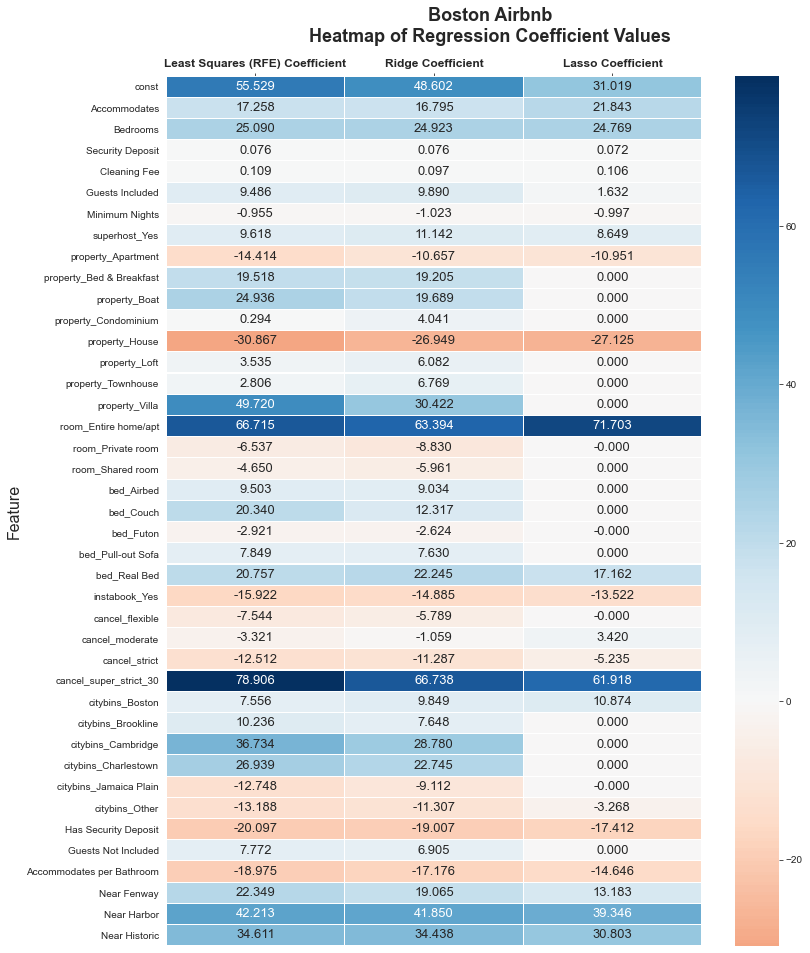

In [39]:
# Code Block 24
# Show coefficient values in a heatmap
plt.figure(figsize=(12,16))
ax = sns.heatmap(all_coeff, linewidths=0.1, center=0, cmap='RdBu', linecolor='white', 
            annot=True, fmt=".3f", annot_kws={"size": 13})

# Use regression titles as labels on top
ax.xaxis.tick_top()  
ax.set_xticklabels(all_coeff.columns.values, fontweight='bold', fontsize=12)

plt.ylabel('Feature', fontsize=16)

plt.suptitle('Boston Airbnb\nHeatmap of Regression Coefficient Values', fontweight='bold', 
          fontsize='18', ha='center', y=.94)

plt.show()

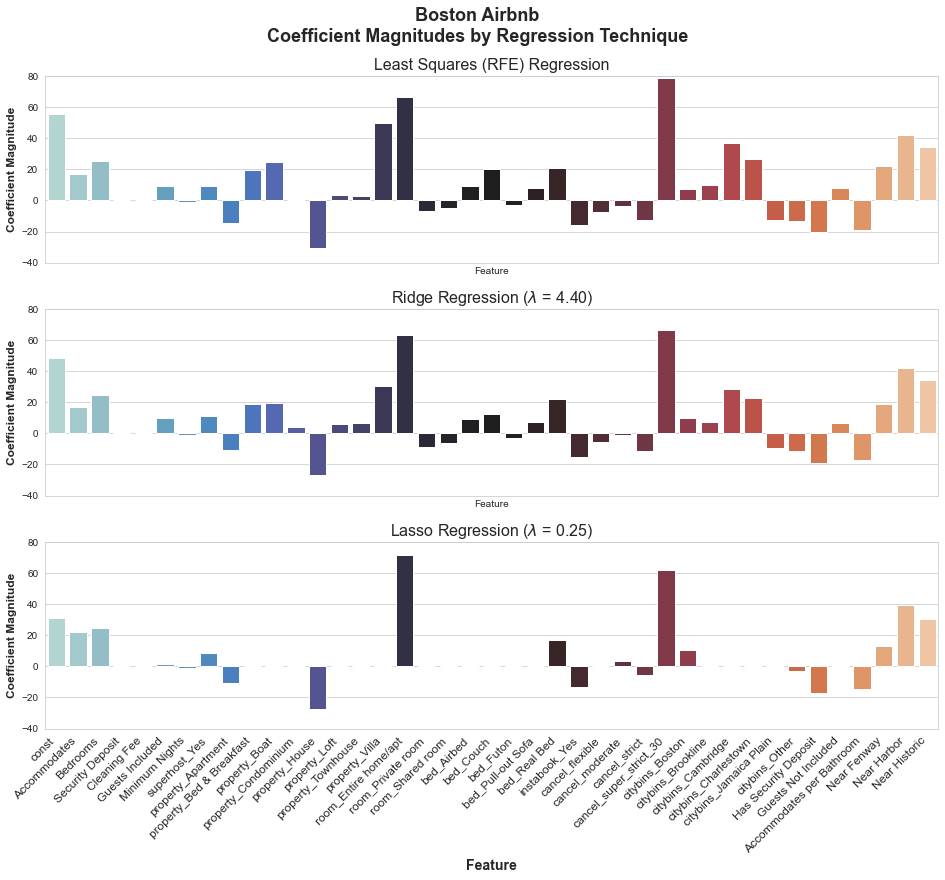

In [41]:
# Code Block 25
plt.figure(figsize=(16,12))
plt.subplots_adjust(hspace=0.25)

# Set overall title for plot
plt.suptitle('Boston Airbnb\nCoefficient Magnitudes by Regression Technique', fontweight='bold', 
          fontsize='18', horizontalalignment='center', y = .96)

# Create a bar plot of regression coefficients for Ridge regression
plt.subplot(311)
chart1 = sns.barplot(x=all_coeff.index, y="Least Squares (RFE) Coefficient", data=all_coeff, palette='icefire')
chart1.set_title("Least Squares (RFE) Regression", fontdict={'fontsize' : 16})
chart1.set_ylim([-40, 80])
chart1.set_ylabel('Coefficient Magnitude', fontweight='bold', fontsize='12', ha='center')
chart1.tick_params(labelbottom=False)   # Remove bottom tick labels

# Create a bar plot of regression coefficients for Lasso regression
plt.subplot(312)
chart2 = sns.barplot(x=all_coeff.index, y=all_coeff["Ridge Coefficient"], palette='icefire')
chart2.set_title("Ridge Regression ($\lambda$ = 4.40)", fontdict={'fontsize' : 16})
chart2.set_ylim([-40, 80])
chart2.set_ylabel('Coefficient Magnitude', fontweight='bold', fontsize='12', ha='center')
chart2.tick_params(labelbottom=False)   # Remove bottom tick labels

# Create a bar plot of regression coefficients for Least Squares regression
plt.subplot(313)
chart3 = sns.barplot(x=all_coeff.index, y=all_coeff["Lasso Coefficient"], palette='icefire')
chart3.set_title("Lasso Regression ($\lambda$ = ___)", fontdict={'fontsize' : 16})
chart3.set_ylim([-40, 80])
chart3.set_ylabel('Coefficient Magnitude', fontweight='bold', fontsize='12', ha='center')
chart3.set_xticklabels(all_coeff.index, rotation=45, ha='right', fontsize='12')
chart3.set_xlabel('Feature', fontweight='bold', fontsize='14', ha='center')


plt.show()

<a id="7"></a>
### Assignment Submission
<a href = "#99">Top</a>
###### The following code uses Javascript to remove scrollbars from the chart you generate

In [42]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Python Assignment 7
### Name: Mark Lowe

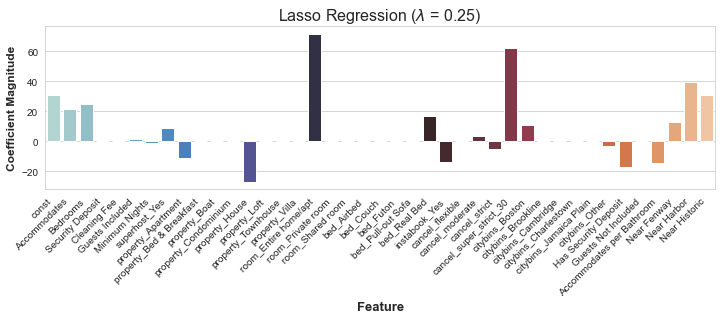

In [43]:
plt.figure(figsize=(12,3))
chart = sns.barplot(x=all_coeff.index, y=all_coeff["Lasso Coefficient"], palette='icefire')
chart.set_title("Lasso Regression ($\lambda$ = 0.25)", fontdict = {'fontsize' : 16})
chart.set_ylabel('Coefficient Magnitude', fontweight='bold', fontsize='12', ha='center')
chart.set_xticklabels(all_coeff.index, rotation=45, ha='right', fontsize='10')
chart.set_xlabel('Feature', fontweight='bold', fontsize='13', ha='center'); plt.show()

In [44]:
print(datetime.datetime.now().isoformat())
print("Your Computer Name is: " + socket.gethostname())
print("Your Computer IP Address is: " + socket.gethostbyname(socket.gethostname()))

2021-03-18T11:02:38.155699
Your Computer Name is: DESKTOP-7PJ8THV
Your Computer IP Address is: 192.168.4.36
